In [2]:
import os
import numpy as np
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.python.summary.summary_iterator import summary_iterator

In [42]:
# read config file for training the model
# will use some of the settings here
with open('Zoobot-backbone-transfer_config.json', 'r') as f:
    config = json.load(f)

In [43]:
# reading the tensorboard logs
log_data = []

log_path = config['log_dir'] + 'logs_train/'
if os.path.exists(log_path):
    log_file = [f for f in os.listdir(log_path) if os.path.isfile(os.path.join(log_path, f))]
    try:
        for e in summary_iterator(log_path+log_file[0]):
            for v in e.summary.value:
                log_data.append([
                    e.step,
                    v.tag, # name of scalar
                    v.simple_value, # value of scalar
                ])
        # print('SUCCESS - Event file loaded: {}'.format(log_path+log_file[0]))
    except:
        print('ERROR - Event file is possibly corrupt: {}'.format(log_path+log_file[0]))

In [44]:
# create dataframe from log_data list
cols = [
    'step',
    'scalar_name',
    'scalar_value',
]

df = pd.DataFrame(log_data, columns=cols)

In [45]:
# we need to treat these variables differently 
# they are stored for each step and not epoch
scalars_with_steps = [
    'Training/Loss', 
    'Training/Loss_box_reg',
    'Training/Loss_classifier', 
    'Training/Loss_objectness',
    'Training/Loss_rpn_box_reg',
    'LR/Learning_rate'
]

In [46]:
# converting steps to epochs
step_size = 9350 // 150

df = (df
    .assign(epoch = lambda _df: (_df.step/step_size).astype(int))
    .assign(epoch = lambda _df: _df.epoch.where(_df.scalar_name.isin(scalars_with_steps), _df.step))
    .assign(step = lambda df_: df_.step.where(df_.scalar_name.isin(scalars_with_steps), df_.step+1))
)

In [47]:
df.groupby(['scalar_name']).agg({
    'step': ['min', 'max', 'count'],
    'epoch': ['min', 'max', 'count'],
    # 'epoch_agg': ['min', 'max', 'count'],
})

step             epoch           
                             min   max count   min  max count
scalar_name                                                  
LR/Learning_rate               1  6583  6583     0  106  6583
Training/Loss                  1  6583  6583     0  106  6583
Training/Loss_box_reg          1  6583  6583     0  106  6583
Training/Loss_classifier       1  6583  6583     0  106  6583
Training/Loss_objectness       1  6583  6583     0  106  6583
Training/Loss_rpn_box_reg      1  6583  6583     0  106  6583
Validation/Loss                1   106  2862     0  105  2862
Validation/Loss_box_reg        1   106  2862     0  105  2862
Validation/Loss_classifier     1   106  2862     0  105  2862
Validation/Loss_objectness     1   106  2862     0  105  2862
Validation/Loss_rpn_box_reg    1   106  2862     0  105  2862

In [ ]:
# save logs as parquet
# df.to_parquet(config['log_dir'] + 'logs_train/logs_FRCNN_{}.gzip'.format(config['model_name']), compression='gzip')

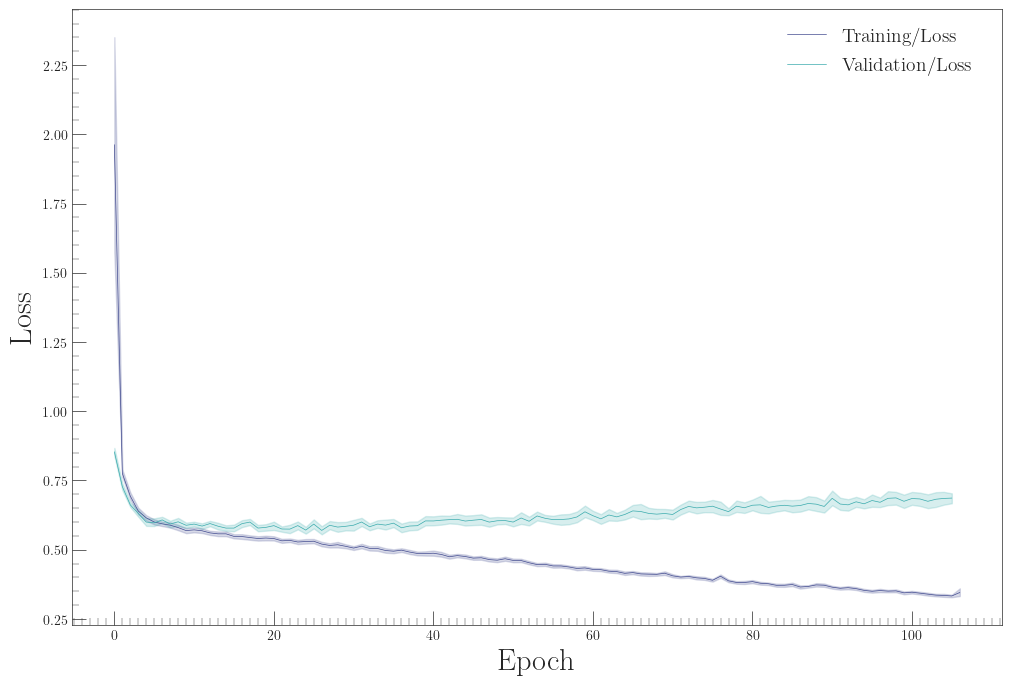

In [48]:
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
})

sns.set_style('ticks', {
    'font.family': ['cm'],
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.bottom': True,
    'xtick.top': False,
    'ytick.left': True,
    'ytick.right': False,
})

palette = sns.color_palette('mako', 2)

model_name = 'Resnet_Imagenet_trainable'
scalar_names = ['Training/Loss', 'Validation/Loss']

df_plot = df[(df['scalar_name'].isin(scalar_names))]

# plot loss: train vs. validation
f, ax = plt.subplots(figsize=(12, 8))

p = sns.lineplot(
    x='epoch', 
    y='scalar_value', 
    hue='scalar_name',
    style='scalar_name',
    markers=False, 
    dashes=False,
    palette=palette,
    # legend='full',
    # alpha=0.8,
    linewidth=.5,
    data=df_plot
)

p.set_xlabel('Epoch', fontsize=22)
p.set_ylabel('Loss', fontsize=22)
plt.setp(ax.spines.values(), linewidth=.5)
# ax.set_xlim(0, 50)
ax.tick_params('both', length=10, width=.5, which='major')
ax.tick_params('both', length=5, width=.3, which='minor')
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1.))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.05))
sns.move_legend(p, "upper left", bbox_to_anchor=(0.75, 1), title='', fontsize=14, frameon=False)

In [ ]:
# F1-score
df_best = df[(df['scalar_name'].isin(['AR/IoU/0.50-0.95/all/10', 'AP/IoU/0.50-0.95/all/100']))]
df_f1 = df_best.pivot(index=['step'], columns='scalar_name', values='scalar_value').reset_index()

# F1 = 2 * (precision * recall) / (precision + recall)
df_f1['f1_score'] = 2 * (df_f1['AP/IoU/0.50-0.95/all/100'] * df_f1['AR/IoU/0.50-0.95/all/10']) / (df_f1['AP/IoU/0.50-0.95/all/100'] + df_f1['AR/IoU/0.50-0.95/all/10'])

In [ ]:
df_f1.sort_values(by='f1_score', ascending=False).head(20)

In [ ]:
df_f1.loc[df_f1['f1_score'].idxmax()]

In [ ]:
# f1 score
f, ax = plt.subplots(figsize=(6, 6))

p = sns.lineplot(
    x='step', 
    y='f1_score', 
    markers=False, 
    dashes=False,
    legend='full',
    # err_style="bars", errorbar=("se", 2),
    # alpha=0.8,
    # linewidth=.5,
    data=df_f1
)

p.set_xlabel('Epoch', fontsize=22)
p.set_ylabel('F1 score', fontsize=22)
plt.setp(ax.spines.values(), linewidth=1.)
ax.tick_params('both', length=10, width=.5, which='major', labelsize=16)
ax.tick_params('both', length=5, width=.3, which='minor', labelsize=12)
# ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(.05))
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(5.))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.005))
ylabels = ['{:,.2f}'.format(x) for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
plt.tight_layout()
# plt.savefig('f1_score.pdf')